# Gravitational orbits

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos
from scipy.integrate import solve_ivp

# Change the common font size
font_size = 12
plt.rcParams.update({'font.size': font_size})

In [2]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [3]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [4]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = -GMm/r.  Several algorithms for integration of 
    ordinary differential equations are now available. 
    """
    def __init__(self, G, m1, m2):
        self.G = G
        self.m1 = m1
        self.m2 = m2
        #mass1 and mass2
        
        
    def U(self, x_1, y_1, x_2, y_2):
        """Potential energy of the form U = -GMm/r."""
        r = np.sqrt((x_1 - x_2)**2 + (y_1 - y_2)**2)
        return -(self.G * self.m1 * self.m2) / r
            
        
    def energy(self, t_pts, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot):
        """Evaluate the energy as a function of time"""
        return self.m1 * (x1_dot**2 + y1_dot**2)/2. + self.m2 * (x2_dot**2 + y2_dot**2)/2. + self.U(x1, y1, x2, y2)
    
    
    def dy_dt(self, t, y):
        """
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x1(t), y[1] = dx1/dt, y[2] = y1(t), y[3] = dy1/dt,
            y[4] = x2(t), y[5] = dx2/dt, y[6] = y2(t), y[7] = dy2/dt,
            
        """
        A = np.sqrt((y[0]-y[4])**2+(y[2]-y[6])**2)
        
        return [y[1], self.G *self.m2 * (y[4]-y[0])/A**3, y[3], self.G *self.m2 * (y[6]-y[2])/A**3,y[5], -self.G *self.m1 * (y[4]-y[0])/A**3,y[7], -self.G *self.m1 * (y[6]-y[2])/A**3]
    
    
    def solve_ode(self, t_pts, x_1_0, x_1_dot_0, 
                  y_1_0,y_1_dot_0, x_2_0,x_2_dot_0,
                  y_2_0,y_2_dot_0, abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x_1_0, x_1_dot_0,y_1_0, y_1_dot_0, x_2_0,x_2_dot_0,y_2_0,y_2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = solution.y

        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
##############################################################################################################
# below is Leapfrop method
    def solve_ode_Leapfrog(self, t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays with zeros
        num_t_pts = len(t_pts)
        x_1 = np.zeros(num_t_pts)
        x_1_dot = np.zeros(num_t_pts)
        x_1_dot_half = np.zeros(num_t_pts)
        x_2 = np.zeros(num_t_pts)
        x_2_dot = np.zeros(num_t_pts)
        x_2_dot_half = np.zeros(num_t_pts)
        y_1 = np.zeros(num_t_pts)
        y_1_dot = np.zeros(num_t_pts)
        y_1_dot_half = np.zeros(num_t_pts)
        y_2 = np.zeros(num_t_pts)
        y_2_dot = np.zeros(num_t_pts)
        y_2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x_1[0] = x_1_0
        x_1_dot[0] = x_1_dot_0
        x_2[0] = x_2_0
        x_2_dot[0] = x_2_dot_0
        y_1[0] = y_1_0
        y_1_dot[0] = y_1_dot_0
        y_2[0] = y_2_0
        y_2_dot[0] = y_2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x_1[i], x_1_dot[i], y_1[i], y_1_dot[i], x_2[i], x_2_dot[i], y_2[i], y_2_dot[i]]
            x_1_dot_half[i] = x_1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x_1[i+1] = x_1[i] + x_1_dot_half[i] * delta_t
            x_2_dot_half[i] = x_2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x_2[i+1] = x_2[i] + x_2_dot_half[i] * delta_t
            y_1_dot_half[i] = y_1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y_1[i+1] = y_1[i] + y_1_dot_half[i] * delta_t
            y_2_dot_half[i] = y_2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y_2[i+1] = y_2[i] + y_2_dot_half[i] * delta_t           
            y = [x_1[i+1], x_1_dot[i], y_1[i+1], y_1_dot[i], x_2[i+1], x_2_dot[i], y_2[i+1], y_2_dot[i]]
            x_1_dot[i+1] = x_1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x_2_dot[i+1] = x_2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y_1_dot[i+1] = y_1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y_2_dot[i+1] = y_2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.

        return x_1, x_1_dot, y_1, y_1_dot, x_2, x_2_dot, y_2, y_2_dot

Notice consider the case mass1(like sun) >> mass2(like earth), we have:

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


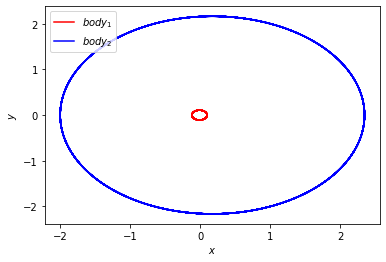

energy = -87.58


In [5]:
# Common plotting time
t_start = 0.
t_end = 10.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Make an orbit
#############################################################
#change G,m1,m2 and initial conditions here!
m1 = 20.
m2 = 1.
G = 20.
o1 = Orbit(G, m1=m1, m2=m2)
x_1_0 = 0.1 
x_1_dot_0 = 0.
y_1_0 = 0.
y_1_dot_0 = 0.7
x_2_0 = - (m1/m2) * x_1_0 
x_2_dot_0 = - (m1/m2) * x_1_dot_0
y_2_0 = - (m1/m2) * y_1_0 
y_2_dot_0 = - (m1/m2) * y_1_dot_0
#############################################################

x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts,x_1_0, x_1_dot_0,y_1_0,y_1_dot_0,x_2_0,x_2_dot_0,y_2_0,y_2_dot_0)


# Make figures of x1 vs y1 and x2 vs y2
plt.subplot(1,1,1)
plt.plot(x_1,y_1,'red',label='$body_1$')
plt.plot(x_2,y_2,'blue',label='$body_2$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

x_1_pts_LF, x_1_dot_pts_LF, y_1_pts_LF, y_1_dot_pts_LF, x_2_pts_LF, x_2_dot_pts_LF, y_2_pts_LF, y_2_dot_pts_LF = o1.solve_ode_Leapfrog(t_pts, x_1_0, x_1_dot_0, y_1_0, y_1_dot_0, x_2_0, x_2_dot_0, y_2_0, y_2_dot_0)

energy_0 = o1.m1 * (x_1_dot_0**2 + y_1_dot_0**2)/2. + o1.m2 * (x_2_dot_0**2 + y_2_dot_0**2)/2. + o1.U(x_1_0, y_1_0, x_2_0, y_2_0)
print(f'energy = {energy_0:.2f}')

## Energy Conservation

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


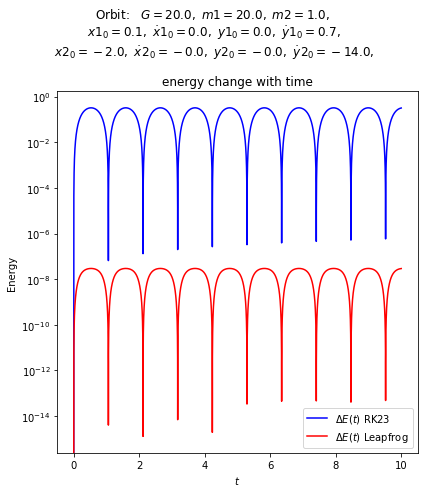

In [6]:
E_tot_pts = o1.energy(t_pts, x_1, x_1_dot_0, y_1, y_1_dot_0, x_2, x_2_dot_0, y_2, y_2_dot_0 )
E_tot_0 = E_tot_pts[0]
E_tot_rel_pts = np.abs((E_tot_pts - E_tot_0)/E_tot_0)
E_tot_pts_LF = o1.energy(t_pts, x_1_pts_LF, x_1_dot_pts_LF, y_1_pts_LF, y_1_dot_pts_LF, x_2_pts_LF, x_2_dot_pts_LF, y_2_pts_LF, y_2_dot_pts_LF)
E_tot_0_LF = E_tot_pts_LF[0]
E_tot_rel_pts_LF = np.abs((E_tot_pts_LF - E_tot_0_LF)/E_tot_0_LF)

fig_2 = plt.figure(figsize=(6,6))
overall_title = 'Orbit:  ' + \
                rf' $G = {o1.G},$' + \
                rf' $m1 = {o1.m1:.1f},$' + \
                rf' $m2 = {o1.m2:.1f},$' + \
                '\n' + \
                rf' $x1_0 = {x_1_0:.1f},$' + \
                rf' $\dot x1_0 = {x_1_dot_0:.1f},$' + \
                rf' $y1_0 = {y_1_0:.1f},$' + \
                rf' $\dot y1_0 = {y_1_dot_0:.1f},$' + \
                '\n' + \
                rf' $x2_0 = {x_2_0:.1f},$' + \
                rf' $\dot x2_0 = {x_2_dot_0:.1f},$' + \
                rf' $y2_0 = {y_2_0:.1f},$' + \
                rf' $\dot y2_0 = {y_2_dot_0:.1f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig_2.suptitle(overall_title, va='baseline')
ax_2a = fig_2.add_subplot(1,1,1)
ax_2a.semilogy(t_pts, E_tot_rel_pts,color='blue', label=r'$\Delta E(t)$ RK23')
ax_2a.semilogy(t_pts, E_tot_rel_pts_LF,color='red', label=r'$\Delta E(t)$ Leapfrog')
ax_2a.set_xlabel(r'$t$')
ax_2a.set_ylabel(r'Energy')
ax_2a.set_title('energy change with time')
ax_2a.legend()
fig_2.tight_layout()